Initially 2274 rows.
596 rows have missing EDSS values and will be dropped...


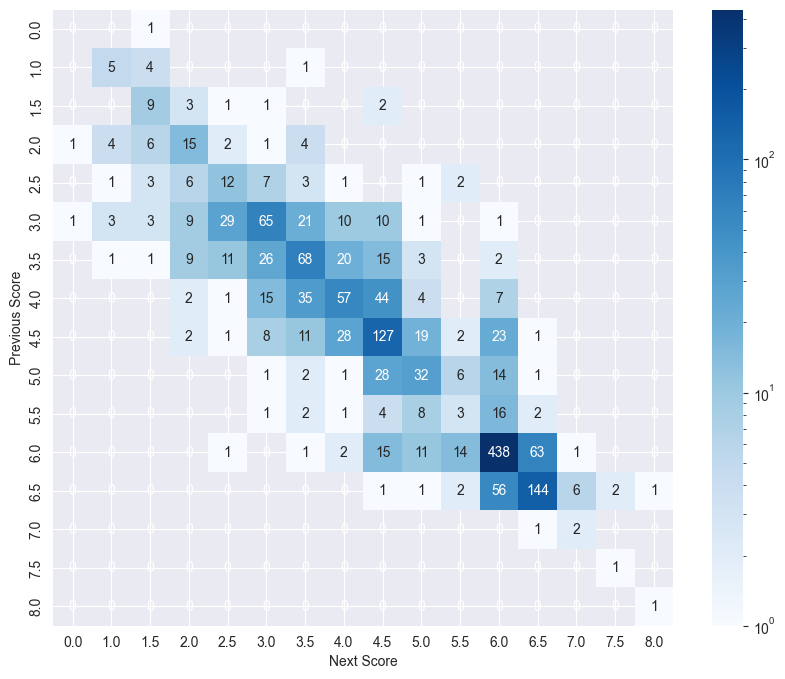

886 rows have a previous EDSS >= 5.0 and will be dropped...
0 rows have a previous EDSS < 0 and will be dropped...
43 rows have missing DMOs and will be dropped...
We have 63 progressions across 58 subjects, out of a total of 749 valid samples.


,Local.Participant,visit.number,age,gender,EDFSCR1L,time_since_diag,time_since_onset,Prev_EDSS,Prev_Timepoint,progression,...,ws_30_avg_w,strlen_30_avg_w,cadence_30_avg_w,strdur_30_avg_w,ws_30_p90_w,cadence_30_p90_w,ws_30_var_w,strlen_30_var_w,wb_60_sum_w,n_days_w
29,10382,T2,61.0,1,6.0,1.272356e+09,1.287476e+09,4.0,T1,1,...,0.84,106.0,94.0,1.25,1.00,103.0,17.0,16.0,7.0,7.0
46,10385,T4,41.0,0,6.0,3.045996e+08,3.656844e+08,4.5,T3,1,...,0.96,116.0,98.0,1.16,1.12,109.0,18.0,14.0,10.0,7.0
74,10393,T2,45.0,1,5.0,2.581911e+08,8.310231e+08,4.0,T1,1,...,0.83,118.0,84.0,1.35,1.03,98.0,19.0,13.0,3.0,7.0
77,10393,T5,46.0,1,6.0,3.052772e+08,8.781092e+08,4.5,T4,1,...,0.86,120.0,84.0,1.34,1.07,100.0,19.0,11.0,4.0,7.0
213,21138,T3,41.0,1,5.0,6.981414e+08,6.981414e+08,3.0,T2,1,...,0.83,111.0,88.0,1.28,0.97,95.0,19.0,14.0,2.0,7.0


In [187]:
#####################################################
# Data preparation and exclusion
#
#####################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import os
from dotenv import load_dotenv

load_dotenv()

data_dir = os.getenv("DATA_DIR", "Dataset/")
min_prev_score = 0
threshold = 5.0
min_progression = 0.5

# read in main MS dataset
data_file_path = data_dir + r"MS_dataset_v.7.3.csv"
cols_from_dataset = ['Local.Participant', 'EDFSCR1L', 'visit.number', 'age', 'gender', 'mstypeonset', 'mstypediag', 'visit.date']
data = pd.read_csv(data_file_path, usecols=cols_from_dataset)

# forward fill within groups to ensure no leakage of demographics between participants
cols_from_dataset = [col for col in cols_from_dataset if col in ['age', 'gender', 'mstypeonset', 'mstypediag']]
for col in cols_from_dataset:
    data[col] = data.groupby('Local.Participant')[col].ffill()

# we need to get the time difference and convert from timedelta to something that the ML models can use - probably unix time
data['time_since_diag'] = (pd.to_datetime(data['visit.date']) - pd.to_datetime(data['mstypediag'])).dt.total_seconds()
data['time_since_onset'] = (pd.to_datetime(data['visit.date']) - pd.to_datetime(data['mstypeonset'])).dt.total_seconds()

# drop cols used for calculation
data = data.drop(['mstypeonset', 'mstypediag', 'visit.date'], axis=1)

# convert gender to 0 and 1
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1})

# Crop down to just the necessary columns
data = data.sort_values(by=['Local.Participant', 'visit.number'])

# shift timepoints and EDSS to get previous as columns
data['Prev_EDSS'] = data.groupby('Local.Participant')['EDFSCR1L'].shift(1)
data['Prev_Timepoint'] = data.groupby('Local.Participant')['visit.number'].shift(1)

# get progression label column
progression_mask = (
    (data['Prev_EDSS'] < threshold) &
    (data['EDFSCR1L'] >= threshold) &
    ((data['EDFSCR1L'] - data['Prev_EDSS']) >= min_progression)
)
data['progression'] = np.where(progression_mask, 1, 0)

transitions = data[progression_mask]  # all the data where a transition happens, just in case.

data['Prev_Timepoint'] = data['Prev_Timepoint'].str.upper()  # needed for later merges
data['visit.number'] = data['visit.number'].str.upper()  # this one is just for consistency

#display(transitions.head(10))

# now that we have a reduced dataset, loop through our weekly dmo aggregations and append the relevant ones to the dataframe
timepoints = ["T1", "T2", "T3", "T4"]  # we don't need DMOs where T5 is previous

dfs_list = []
for timepoint in timepoints:
    feature_file_path = data_dir + f"/{timepoint} Aggregated DMO Data_V7.3/cvs-{timepoint}-weekly_agg_all-21-01-2026.csv"
    temp_df = pd.read_csv(feature_file_path)
    dfs_list.append(temp_df)

features_df = pd.concat(dfs_list, ignore_index=True)
data = pd.merge(data, features_df, left_on=['Local.Participant', 'Prev_Timepoint'],
                right_on=['participant_id', 'visit_type'], how='left')

data = data.drop(['participant_id', 'visit_type'], axis=1)
data = data.dropna(subset=['Prev_Timepoint'])

# Data cleaning - will monitor number of rows throughout
print(f"Initially {len(data)} rows.")

# get rid of participants where either current or previous EDSS is missing
count_before = len(data)
data = data.dropna(subset=['EDFSCR1L', 'Prev_EDSS'])
print(f"{count_before - len(data)} rows have missing EDSS values and will be dropped...")

# Create matrix of prev -> next EDSS scores
prev_scores = data['Prev_EDSS'].to_numpy().tolist()
next_scores = data['EDFSCR1L'].to_numpy().tolist()

# extract the unique scores
scores = list(set(prev_scores).union(set(next_scores)))
scores.sort()
n_scores = len(scores)

# Create transition matrix
# Note some of these transitions will be for people with missing DMOs
transition_matrix = pd.DataFrame(
    np.zeros((n_scores, n_scores), dtype=int),
    index=scores,
    columns=scores)

for prev_score, next_score in zip(prev_scores, next_scores):
    transition_matrix.loc[prev_score, next_score] += 1

# Pretty print transition matrix as heatmap
plt.subplots(figsize=(10, 8))
ax = plt.subplot(111)
sns.heatmap(transition_matrix.values, annot=True, cmap="Blues", ax=ax, fmt='d', norm=colors.LogNorm())
ax.set_xlabel('Next Score')
ax.set_ylabel('Previous Score')
ax.xaxis.set_ticklabels(scores)
ax.yaxis.set_ticklabels(scores)
plt.show()

# Exclude participants with Prev_EDSS >= threshold as they have already progressed:
count_before = len(data)
high_prev_edss_mask = (data['Prev_EDSS'] >= threshold)
print(f"{sum(high_prev_edss_mask)} rows have a previous EDSS >= {threshold} and will be dropped...")
data = data.drop(data[high_prev_edss_mask].index)

# Exclude participants with Prev_EDSS < min_prev_score as they are highly unlikely to progress, and may have different mobility patterns
count_before = len(data)
low_prev_edss_mask = (data['Prev_EDSS'] < min_prev_score)
print(f"{sum(low_prev_edss_mask)} rows have a previous EDSS < {min_prev_score} and will be dropped...")
data = data.drop(data[low_prev_edss_mask].index)

# drop all remaining NAN rows, which will be due to missing DMOs
count_before = len(data)
data = data.dropna()
print(f"{count_before - len(data)} rows have missing DMOs and will be dropped...")

num_progressions = len(data[data["progression"] == 1])
unique_sub_progressions = len(data[data["progression"] == 1]['Local.Participant'].unique())

print(
    f"We have {num_progressions} progressions across {unique_sub_progressions} subjects, out of a total of {len(data)} valid samples.")

display(data[data["progression"] == 1].head(5))

#labels_df.to_csv("data.csv", index=False)

# need to be at least 1 (not 0.5) to change
# subset of EDSS and normalise?
# balance dataset - Done very good

# undersampled_df = labels_df.groupby('progression').sample(labels_df.groupby('progression').size().min())

ws_10_p90_w          0.084532
cadence_all_var_w    0.078218
ws_30_p90_w          0.066344
ws_30_avg_w          0.065810
strdur_all_var_w     0.061135
strlen_30_avg_w      0.055172
ws_1030_avg_w        0.048729
strlen_1030_avg_w    0.030462
wbdur_all_p90_w      0.026312
cadence_30_p90_w     0.023967
cadence_30_avg_w     0.016527
n_days_w             0.011244
wb_60_sum_w          0.009329
ws_30_var_w          0.005349
wbdur_all_avg_w     -0.010281
strlen_30_var_w     -0.013456
wb_30_sum_w         -0.015339
cadence_all_avg_w   -0.018514
strdur_all_avg_w    -0.018967
Prev_EDSS           -0.022394
gender              -0.022429
time_since_diag     -0.039869
wbdur_all_var_w     -0.044900
strdur_30_avg_w     -0.048785
wbsteps_all_sum_w   -0.056665
walkdur_all_sum_w   -0.060762
wb_10_sum_w         -0.069205
wb_all_sum_w        -0.075202
age                 -0.104748
time_since_onset    -0.124297
dtype: float64

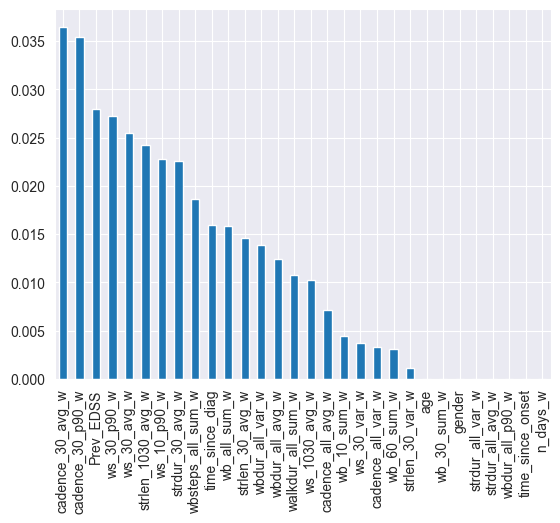

Removed irrelevant (i.e. MI == 0) features


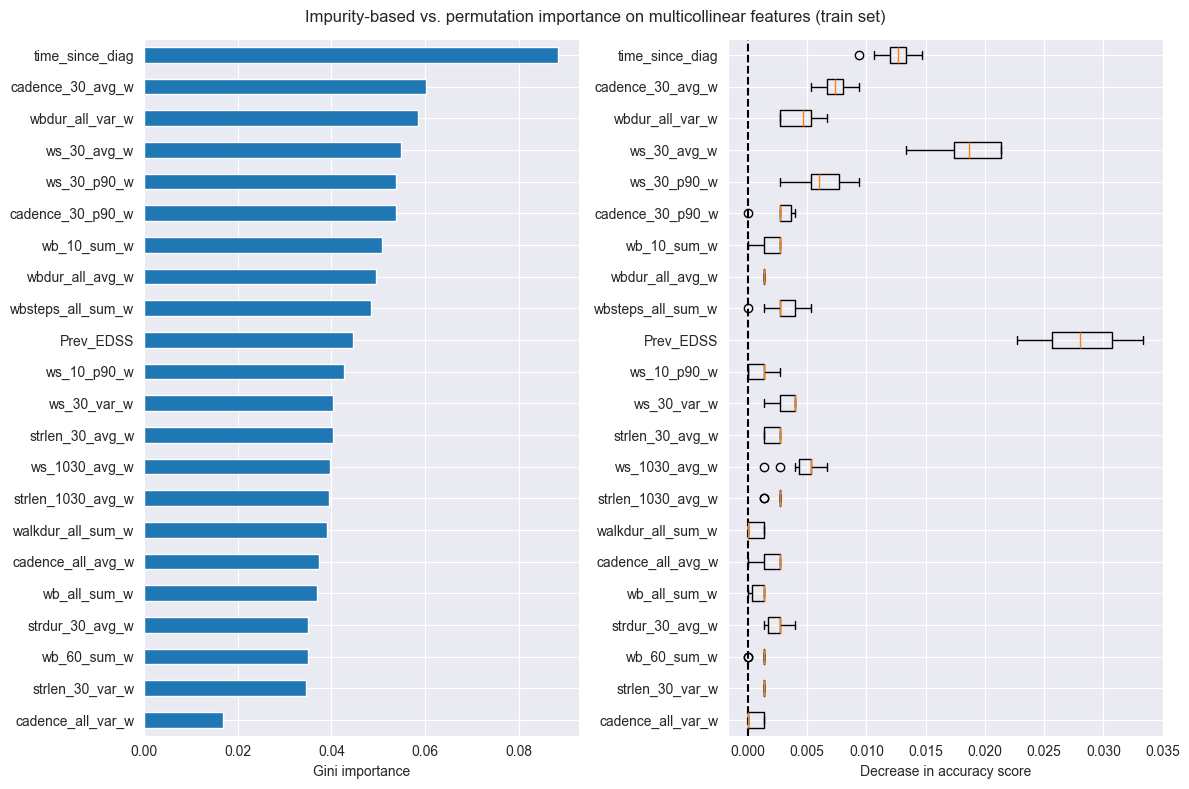

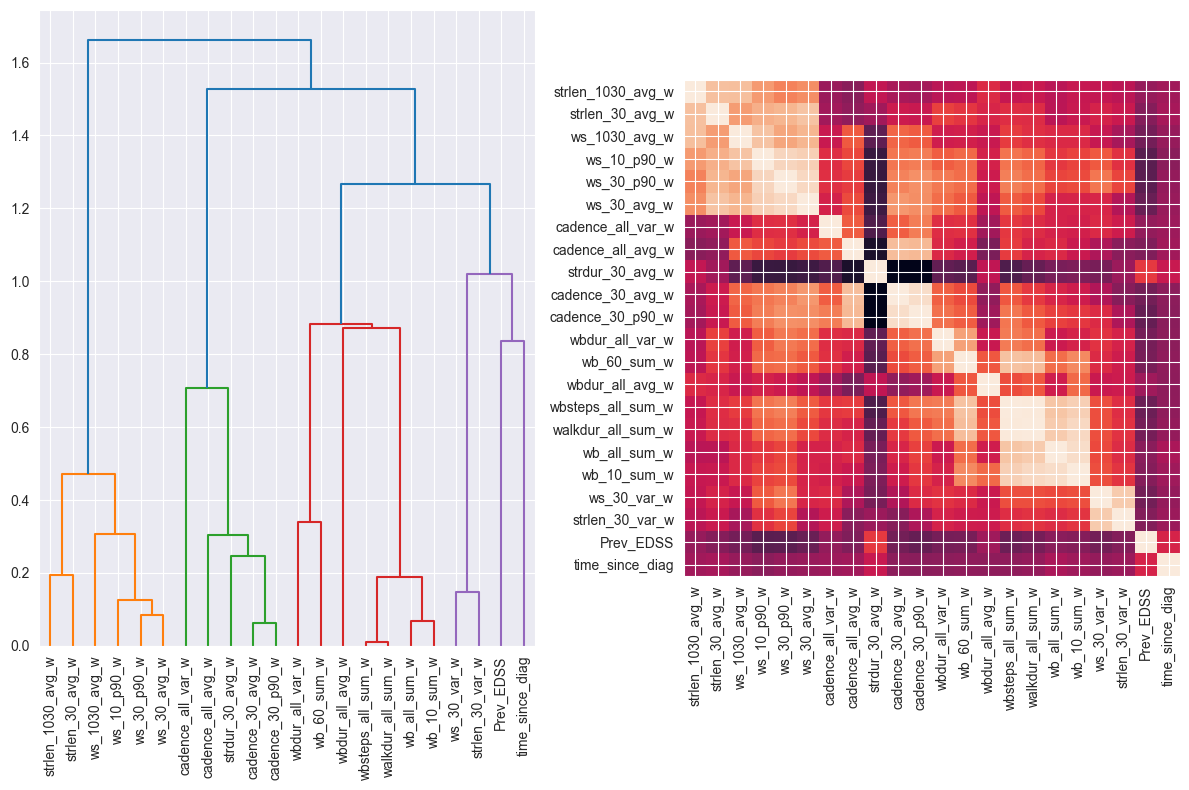

Baseline accuracy on test data: 0.91
Baseline accuracy on test data with features removed: 0.91


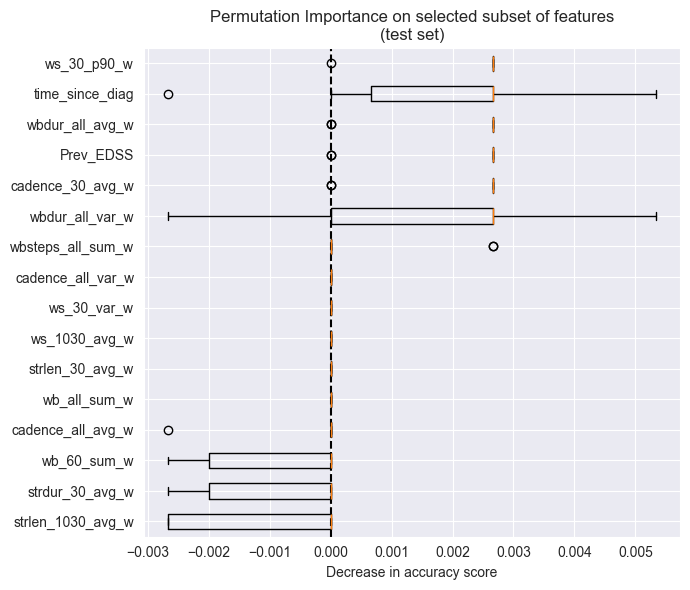

Explained variance: [0.36585282 0.16609459 0.13318357 0.06785996 0.06126392 0.05095805
 0.03750101 0.03636161 0.02991218 0.01430558]
Cumulative: [0.36585282 0.53194741 0.66513098 0.73299094 0.79425485 0.8452129
 0.88271391 0.91907551 0.94898769 0.96329327]
Shape of Original Dataset: (749, 22)
Shape after PCA: (749, 10)


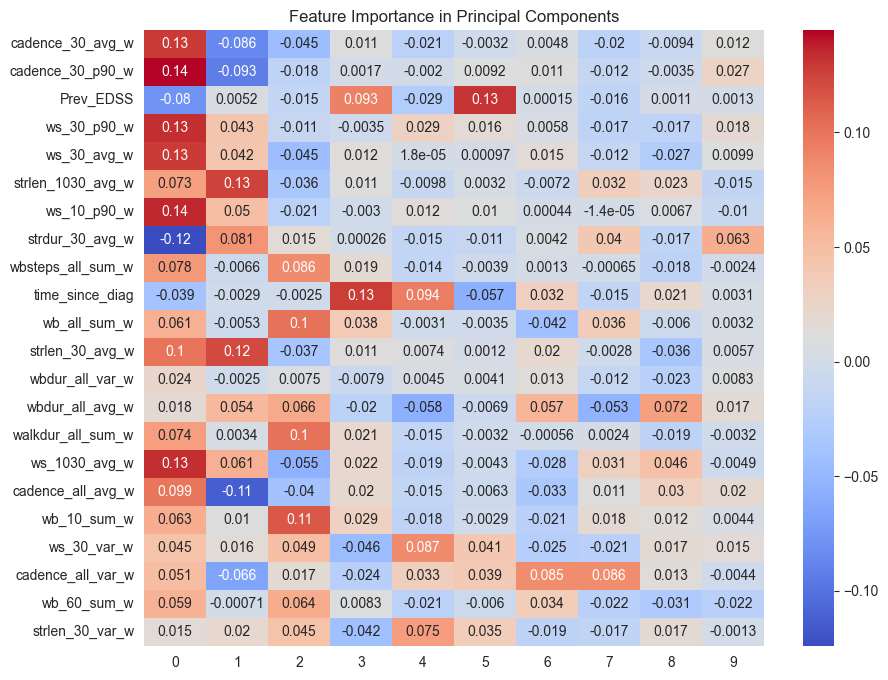

InvalidIndexError: (slice(None, None, None), 0)

In [200]:
###################################################################
# Feature selection and exclusion
# Note that in data preparation rows with NaN values are excluded.
# Removing these features (columns) may increase the data,
# if that feature is the reason for NaN exclusion.
# ToDo Test with various thresholds
###################################################################

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

mi_threshold = 0.005
feature_selection_type = None


def rf_feature_analysis(X, y, random_state=42):
    model = RandomForestRegressor(random_state=random_state)
    model.fit(X, y)

    # The importance of a feature is how much this feature is used in each tree of the forest.
    # It is computed as the (normalized) total reduction of the criterion brought by that feature.
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    fig, ax = plt.subplots()
    importances = pd.Series(model.feature_importances_, index=np.array(X.columns))
    importances = pd.Series(data=importances, index=X.columns).sort_values(ascending=False)
    importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importance using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()


def rf_perm_feature_analysis(X, y, random_state=42):
    model = RandomForestClassifier(random_state=random_state)
    model.fit(X, y)

    result = permutation_importance(model, X, y, n_repeats=10, random_state=random_state, n_jobs=2)

    fig, ax = plt.subplots()
    importances = pd.Series(result.importances_mean, index=np.array(X.columns))
    importances = pd.Series(data=importances, index=X.columns).sort_values(ascending=False)
    importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importance using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()


def plot_permutation_importance(clf, X, y, ax, indexes=None, random_state=42):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=random_state, n_jobs=2)
    if indexes is not None:
        perm_sorted_idx = indexes
    else:
        perm_sorted_idx = result.importances_mean.argsort()

    tick_labels_dict = {"tick_labels": X.columns[perm_sorted_idx]}
    ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
    ax.axvline(x=0, color="k", linestyle="--")
    return ax


def rf_combine_feature_analysis(X, y, random_state=42):
    clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf.fit(X, y)

    mdi_importances = pd.Series(clf.feature_importances_, index=X.columns)
    tree_importance_sorted_idx = np.argsort(clf.feature_importances_)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(clf, X, y, ax2, tree_importance_sorted_idx)
    ax2.set_xlabel("Decrease in accuracy score")
    fig.suptitle(
        "Impurity-based vs. permutation importance on multicollinear features (train set)"
    )
    _ = fig.tight_layout()
    plt.show()


def mi_feature_analysis(X, y, mi_threshold=0.0, random_state=42):
    # feature importance analysis
    pearson_corr = X.corrwith(y).sort_values(ascending=False)
    display(pearson_corr)

    # mutual information gain for feature removal
    mi = mutual_info_classif(X, y, random_state=random_state, n_jobs=-1)
    mi = pd.Series(data=mi, index=X.columns).sort_values(ascending=False)
    mi.plot(kind='bar')
    plt.show()

    # delete features with 0 information gain
    mi = mi[mi > mi_threshold]

    X = X[mi.index]

    return X


def show_correlation(X):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    corr = spearmanr(X).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
    )
    dendro_idx = np.arange(0, len(dendro["ivl"]))

    ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax2.set_yticklabels(dendro["ivl"])
    _ = fig.tight_layout()
    plt.show()

    return dist_linkage


def cluster_selection(X, y, dist_linkage, threshold=0.15, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, train_size=0.5)

    clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf.fit(X_train, y_train)
    print(f"Baseline accuracy on test data: {clf.score(X_test, y_test):.2}")

    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    selected_features_names = X.columns[selected_features]

    X_train_sel = X_train[selected_features_names]
    X_test_sel = X_test[selected_features_names]

    clf_sel = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf_sel.fit(X_train_sel, y_train)
    print(
        "Baseline accuracy on test data with features removed:"
        f" {clf_sel.score(X_test_sel, y_test):.2}"
    )

    fig, ax = plt.subplots(figsize=(7, 6))
    plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
    ax.set_title("Permutation Importance on selected subset of features\n(test set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    plt.show()

    return X[selected_features_names]


def pca_selection(X, random_state=42):
    # normalisation
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=0.95, svd_solver='full', random_state=random_state)  # keep 95% of variance
    X_pca = pd.DataFrame(data=pca.fit_transform(X_scaled))
    print("Explained variance:", pca.explained_variance_ratio_)
    print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))
    print("Shape of Original Dataset:", X_scaled.shape)
    print("Shape after PCA:", X_pca.shape)

    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(loadings, annot=True, cmap='coolwarm', yticklabels=np.array(X.columns))
    plt.title('Feature Importance in Principal Components')
    plt.show()

    return X_pca


# drop irrelevant or 'cheating' columns
y_data = data["progression"].reset_index(drop=True)  # can be data["progression"] or data["multiclass_progression"]
labels_X_all = data.reset_index(drop=True)
X_data = data.drop(["progression", "Local.Participant", "EDFSCR1L",
                    "visit.number", "Prev_Timepoint"], axis=1)

# remove any feature with an MI pf 0
X_data = mi_feature_analysis(X_data, y_data, mi_threshold=0)
print("Removed irrelevant (i.e. MI == 0) features")

# rf_feature_analysis(X_data, y_data)
# rf_perm_feature_analysis(X_data, y_data)
rf_combine_feature_analysis(X_data, y_data)

dist_linkage = show_correlation(X_data)
X_data_cluster = cluster_selection(X_data, y_data, dist_linkage)

X_data_pca = pca_selection(X_data)

if (feature_selection_type == "cluster"):
    X_data = X_data_cluster
elif (feature_selection_type == "mi"):
    if (mi_threshold > 0):
        X_data = mi_feature_analysis(X_data, y_data, mi_threshold=mi_threshold)
elif (feature_selection_type == "pca"):
    X_data = X_data_pca
elif (feature_selection_type is not None):
    print("Feature selection type not recognized")

print("Feature selection:", feature_selection_type)
print("X_data shape:", X_data.shape)

In [158]:
######################################################################
# Resampling data (NOT USED)
# Note this needs to be tidied up into the experimentation framework
######################################################################

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

do_data_sampling = False


def get_unsampled(x_data, x_sampled, y_data):
    # Create dataframe with column showing whether data has been sampled or not
    # Shown by column "_merge" value "both" == sampled "left_only" == not sampled
    merged = x_data.merge(x_sampled.drop_duplicates(), how='left', indicator=True)
    # Get indices of rows which have not been sampled
    unsampled_indices = merged.index[merged['_merge'] == "left_only"].tolist()
    X_unsampled = X_data.iloc[unsampled_indices]
    y_unsampled = y_data.iloc[unsampled_indices]
    return X_unsampled, y_unsampled


if (do_data_sampling):
    rus = RandomUnderSampler(random_state=42)
    ros = RandomOverSampler(random_state=42)
    smote = SMOTE(random_state=42)
    adasyn = ADASYN(random_state=42)

    X_data, y_data = smote.fit_resample(X_data, y_data)


In [159]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

n_iter=20
random_state=42
verbose = 0
n_jobs=-1
cv=5
scoring='f1'

svm_model = BayesSearchCV(
    SVC(random_state=42),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),  # Regularization parameter
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),  # Kernel coefficient
        'kernel': Categorical(['rbf', 'poly', 'sigmoid']),  # Type of kernel
        'degree': Integer(1, 5)  # Degree for poly kernel
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

mlp_model = BayesSearchCV(
    MLPClassifier(random_state=random_state, max_iter=1000),
    {
        'hidden_layer_sizes': Integer(1, 128),  # Different architectures
        'activation': Categorical(['tanh', 'relu']),
        'solver': Categorical(['sgd', 'adam']),
        'alpha': Real(1e-5, 1e-1, prior='log-uniform'),  # L2 penalty (regularization)
        'learning_rate': Categorical(['constant', 'adaptive']),
        'learning_rate_init': Real(1e-4, 1e-1, prior='log-uniform')  # Initial learning rate
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

knn_model = BayesSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': Integer(1, 50),
        'weights': Categorical(['uniform', 'distance']),
        'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': Integer(10, 50),
        'p': Integer(1, 2)  # 1 = Manhattan, 2 = Euclidean distance
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

xgb_model = BayesSearchCV(
    XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss'),
    {
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(3, 10),
        'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
        'subsample': Real(0.5, 1.0, prior='uniform'),  # Fraction of samples used for fitting
        'colsample_bytree': Real(0.5, 1.0, prior='uniform'),  # Fraction of features used per tree
        'gamma': Real(1e-6, 5, prior='log-uniform'),  # Min loss reduction for split
        'reg_alpha': Real(1e-5, 10, prior='log-uniform'),  # L1 regularization
        'reg_lambda': Real(1e-5, 10, prior='log-uniform')  # L2 regularization
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

rf_model = BayesSearchCV(
    RandomForestClassifier(random_state=random_state),
    {
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 10),
        'max_features': Categorical(['sqrt', 'log2', None]),  # Number of features to consider at each split
        'bootstrap': Categorical([True, False]),
        'criterion': Categorical(['gini', 'entropy'])
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

dt_model = BayesSearchCV(
    DecisionTreeClassifier(random_state=random_state),
    {
        'criterion': Categorical(['gini', 'entropy']),
        'max_depth': Integer(3, 30),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'ccp_alpha': Real(0.0, 0.1, prior='uniform')  # Cost-Complexity Pruning alpha
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

lr_model = BayesSearchCV(
    LogisticRegression(random_state=random_state, solver='saga', max_iter=5000),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),  # Inverse of regularization strength
        'penalty': Categorical(['l1', 'l2', 'elasticnet']),
        'l1_ratio': Real(0, 1, prior='uniform'),  # Only used if penalty='elasticnet'
        'fit_intercept': Categorical([True, False])
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

Best Parameters: OrderedDict({'C': 0.08341564384216595, 'degree': 4, 'gamma': 3.389034515643755, 'kernel': 'rbf'})
Best Score: 0.8011435401933328
Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81       136
           1       0.17      0.57      0.26        14

    accuracy                           0.69       150
   macro avg       0.55      0.64      0.53       150
weighted avg       0.87      0.69      0.76       150



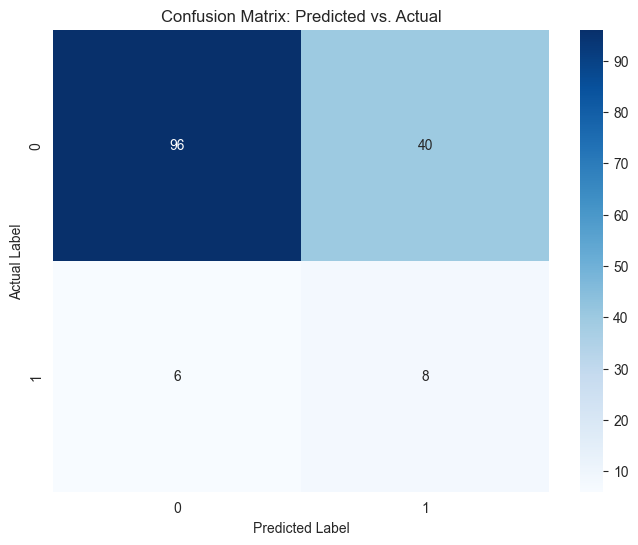

Fold 0
Accuracy: 0.69
Precision: 0.87
Recall: 0.69
F1 Score: 0.76
Fold 1
Accuracy: 0.78
Precision: 0.91
Recall: 0.78
F1 Score: 0.82
Fold 2
Accuracy: 0.73
Precision: 0.89
Recall: 0.73
F1 Score: 0.78
Fold 3
Accuracy: 0.71
Precision: 0.94
Recall: 0.71
F1 Score: 0.79
Fold 4
Accuracy: 0.70
Precision: 0.93
Recall: 0.70
F1 Score: 0.77


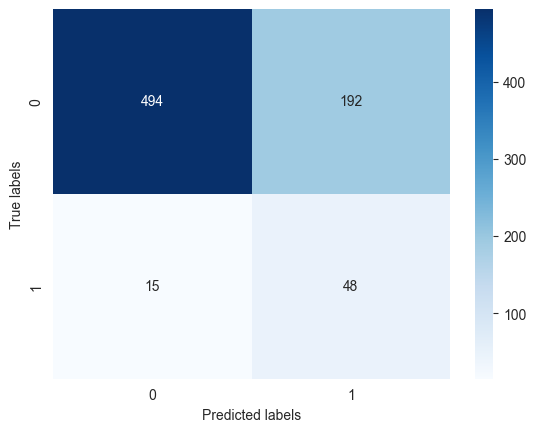

In [197]:
######################################################################
# TEST Classification / Prediction
# Note this needs to be tidied up into the experimentation framework
######################################################################

from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

#import faulthandler
#import signal

#faulthandler.register(signal.SIGINT.value) # I'm not sure what this was doing but it wasn't working for me

# Data normalisation (Not the impact of this needs to be tested)
# e.g. StandardScaler, MinMaxScaler, RobustScaler
# If columns have different (e.g. skewed) distributions that may need different normalisations
# e.g. Log normalisation
# Note that StandardScaler combined with small data will hang SVC, MinMaxScaler works
scaler = MinMaxScaler()
cv_folds = 5


def do_cv(model, X_data, y_data, n_splits=cv_folds):
    # requires: set_config(transform_output="pandas")
    # transformer = ColumnTransformer([('standard_scaler', ss, feature_cols)],
    #                                 remainder='passthrough',
    #                                 verbose_feature_names_out=False)

    combined_cm = None
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for i, (train_split_indices, test_split_indices) in enumerate(kf.split(X_data)):

        X_train_split = X_data.iloc[train_split_indices]
        X_test_split = X_data.iloc[test_split_indices]
        y_train_split = y_data.iloc[train_split_indices]
        y_test_split = y_data.iloc[test_split_indices]

        X_train_scaled = scaler.fit_transform(X_train_split)
        X_test_scaled = scaler.transform(X_test_split)

        # sample weighting
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_split)

        model.fit(X_train_scaled, y_train_split, sample_weight=sample_weights)

        y_pred = model.predict(X_test_scaled)

        print(f"Fold {i}")
        print(f"Accuracy: {accuracy_score(y_test_split, y_pred):.2f}")
        print(f"Precision: {precision_score(y_test_split, y_pred, average='weighted', zero_division=0):.2f}")
        print(f"Recall: {recall_score(y_test_split, y_pred, average='weighted', zero_division=0):.2f}")
        print(f"F1 Score: {f1_score(y_test_split, y_pred, average='weighted', zero_division=0):.2f}")

        cm = confusion_matrix(y_test_split, y_pred)
        if combined_cm is None:
            combined_cm = cm
        else:
            combined_cm = combined_cm + cm

    return combined_cm


def show_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.title('Confusion Matrix: Predicted vs. Actual')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


# train test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# scale the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# sample weighting
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = svm_model

model.fit(X_train, y_train, sample_weight=sample_weights)
# Print the best parameters
print(f"Best Parameters: {model.best_params_}")
print(f"Best Score: {model.best_score_}")
model = model.best_estimator_  # gets the best estimator so we're not doing bayesian searching again on each fold
show_evaluation(model, X_test, y_test)

# Annoyingly cross_val_score and cross_val_predict can differ ???
conf_mat = do_cv(model, X_data, y_data)

# Pretty print confusion matrix

ax = plt.subplot()

cm = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(cm, annot=True, cmap="Blues", ax=ax, fmt='d')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


def fit_and_evaluate(model, model_name, X_train, X_test, y_train, y_test, X_resampled, y_resampled):
    print(f"\n{'=' * 40}")
    print(f"Training {model_name}...")
    print(f"{'=' * 40}")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    model_performance.append({
        'Model': model_name,
        'Best Score (CV)': model.best_score_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Best Params': model.best_params_
    })

    print(f"Best CV Score: {model.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return model.best_estimator_


def get_metrics_from_cm(cm):
    tn, fp, fn, tp = cm.values.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score
    }


def evaluate_model(model):
    conf_mat = do_cv(model, X_data, y_data)
    cm = pd.DataFrame(conf_mat, range(2), range(2))
    metrics = get_metrics_from_cm(cm)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, cmap="Blues", ax=ax, fmt='d')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    plt.show()

    return metrics


# all models in one dict with names
models_dict = {
    "SVM": svm_model,
    "MLP": mlp_model,
    "KNN": knn_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "Logistic Regression": lr_model
}

model_performance = []

for name, model in models_dict.items():
    fit_and_evaluate(model, name, X_train, X_test, y_train, y_test, X_data, y_data)
    best_model = fit_and_evaluate(model, name, X_train, X_test, y_train, y_test, X_data, y_data)
    metrics = evaluate_model(best_model)
    display(metrics)

results_df = pd.DataFrame(model_performance)
results_df = results_df.sort_values(by='F1 Score', ascending=False)

# get best model and retrain
print("training best model...")
best_model = models_dict[results_df["Model"].iloc[0]]
best_model.fit(X_train, y_train)

print("\nModel Comparison Table:")
display(results_df)

In [ ]:
# un-normalise the data and try to find out which samples were misclassified
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

indexed_train_predictions = y_train.reset_index()
indexed_train_predictions["Prediction"] = train_predictions
indexed_train_predictions.index = indexed_train_predictions["index"]
indexed_train_predictions = indexed_train_predictions.drop(["index"], axis=1)

indexed_test_predictions = y_test.reset_index()
indexed_test_predictions["Prediction"] = test_predictions
indexed_test_predictions.index = indexed_test_predictions["index"]
indexed_test_predictions = indexed_test_predictions.drop(["index"], axis=1)

predictions_to_be_appended = pd.concat([indexed_train_predictions, indexed_test_predictions], axis=0)
predictions_to_be_appended["misclassified"] = abs(
    predictions_to_be_appended["Prediction"] - predictions_to_be_appended["progression"])
predictions_to_be_appended = predictions_to_be_appended.drop(["progression"], axis=1)

original_data_with_predictions = labels_X_all.join(predictions_to_be_appended)

display(original_data_with_predictions[original_data_with_predictions["misclassified"] == 1])

In [ ]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)

prog_group = original_data_with_predictions[original_data_with_predictions["progression"] == 1]
no_prog_group = original_data_with_predictions[original_data_with_predictions["progression"] == 0]

feature_cols = [c for c in original_data_with_predictions.columns if c != "progression"]

for col in feature_cols:
    plt.figure(figsize=(6, 4))

    if pd.api.types.is_numeric_dtype(original_data_with_predictions[col]):

        sns.kdeplot(data=no_prog_group, x=col, fill=True,
                    color='forestgreen', label='No Progression', alpha=0.3, linewidth=2)
        sns.kdeplot(data=prog_group, x=col, fill=True,
                    color='crimson', label='Progression', alpha=0.4, linewidth=2)

        plt.ylabel('Density')
        plt.legend()

    else:
        temp_df = original_data_with_predictions.groupby('progression')[col].value_counts(normalize=True).rename(
            'proportion').reset_index()
        temp_df['progression_label'] = temp_df['progression'].map({0: 'No Progression', 1: 'Progression'})

        sns.barplot(data=temp_df, x=col, y='proportion', hue='progression_label',
                    palette={'No Progression': 'forestgreen', 'Progression': 'crimson'}, edgecolor='black')

        plt.ylabel('Proportion')
        plt.legend(title=None)

    plt.title(f'{col}')
    plt.xlabel(col)

    sns.despine()

    plt.tight_layout()
    plt.show()